<a href="https://colab.research.google.com/github/khalil753/Bio-Project/blob/master/CleanTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting libraries and defining global variables**

In [0]:
import fastai
from fastai.vision import *
from fastai.widgets import *

import numpy as np
import pandas as pd

from pathlib import Path
import os
from os import listdir

import matplotlib as mpl
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(r"/content/gdrive/My Drive/Mestría en Física de Sistemas Complejos/Tercer semestre/Inference in Biological Systems/Project")
path_data = path/'data'
path_losses = path_data/"Losses"
classes = ['healthy', 'tumor', 'injury']

In [0]:
second_loop = True
model_folder = Path("Model 3") if second_loop else Path("Model 2")

# **Training the model with the clean dataset**

## *Loading Data and Model* 

In [0]:
tfms = get_transforms(do_flip=True)

train = pd.read_csv(path_data/"Clean Data"/"train.csv")
if second_loop:
  train = train.loc[train["clean2"]==True]
else:
  train = train.loc[train["clean"]==True]
val = pd.read_csv(path_data/"Clean Data"/"val.csv")

data = (ImageList.from_df(train.append(val), path_data)
                 .split_from_df()
                 .label_from_df(classes=classes)
                 .transform(tfms, size=32)
                 .databunch(bs=100, num_workers=16)
                 .normalize(imagenet_stats))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

## *Training the fully connected layers of the NN*

In [0]:
training = True

In [0]:
if training:
  learn.fit_one_cycle(15, max_lr=0.002)

epoch,train_loss,valid_loss,accuracy,time
0,1.350320,0.993740,0.600848,00:39
1,1.045777,0.854092,0.636699,00:39
2,0.798413,0.781865,0.644636,00:39
3,0.610123,0.637376,0.706349,00:39
4,0.510948,0.614889,0.706897,00:39
5,0.463038,0.598645,0.712370,00:38
6,0.430015,0.580120,0.728654,00:39
7,0.419899,0.582460,0.722770,00:40
8,0.401627,0.579580,0.732895,00:39
9,0.381293,0.570487,0.726875,00:39


In [0]:
if training:
  learn.save(model_folder/"stage-1")



## *Fine tuning the model*

In [0]:
if training:
  learn.load(model_folder/'stage-1')
  learn.unfreeze()
  learn.fit_one_cycle(10, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.354687,0.561700,0.717843,00:40
1,0.350873,0.617363,0.711002,00:40
2,0.342816,0.578866,0.734127,00:40
3,0.333290,0.584537,0.723727,00:40
4,0.322853,0.547350,0.728790,00:40
5,0.306196,0.594249,0.712507,00:41
6,0.296198,0.573149,0.729064,00:41
7,0.284463,0.609778,0.705802,00:41
8,0.288649,0.596307,0.713054,00:41
9,0.287328,0.590216,0.715791,00:41


In [0]:
if training: 
  learn.save(model_folder/'stage-1')

# **Studying the new Lossses**

In [0]:
calculating_losses = True

### Calculating Validation an Training Loss

In [0]:
if calculating_losses:
  tfms = get_transforms(do_flip=True)

  train = pd.read_csv(path_data/"Clean Data"/"train.csv")
  val = pd.read_csv(path_data/"Clean Data"/"val.csv")

  data = (ImageList.from_df(train.append(val), path_data)
                  .split_from_df()
                  .label_from_df(classes=classes)
                  .transform(tfms, size=32)
                  .databunch(bs=100, num_workers=16)
                  .normalize(imagenet_stats))

In [0]:
if calculating_losses:
  learn.load(model_folder/'stage-2')

In [0]:
if calculating_losses:
  learn.data = data
  val_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)
  train_interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Train)

In [0]:
if calculating_losses:
  n = 3 if second_loop else 2
  (val_losses, val_idxs), (train_losses, train_idxs) = val_interp.top_losses(), train_interp.top_losses()
  torch.save(train_losses, path_losses/f'train_losses{n}.pt')
  torch.save(train_idxs, path_losses/f'train_idxs{n}.pt')
  torch.save(val_losses, path_losses/f'val_losses{n}.pt')
  torch.save(val_idxs, path_losses/f'val_idxs{n}.pt')

## *Saving Predictions and Confusion Matrix*

We save the predictions to not have to recalculate them in the future

In [0]:
if calculating_losses:
  cm = val_interp.confusion_matrix()
  preds = val_interp.preds
  n = 3 if second_loop else 2
  np.save(path_data/"Confusion Matrices"/f"CM{n}", cm)
  np.save(path_data/"Preds"/f"p{n}", preds)

### Plotting Loss Histograms

In [0]:
n = 3 if second_loop else 2
train_losses = torch.load(path_losses/f'train_losses{n}.pt')
val_losses = torch.load(path_losses/f'val_losses{n}.pt')
losses = [train_losses, val_losses]

train_idxs = torch.load(path_losses/f'train_idxs{n}.pt')
val_idxs = torch.load(path_losses/f'val_idxs{n}.pt')
losses = [train_losses, val_losses]
idxs = [train_idxs, val_idxs]

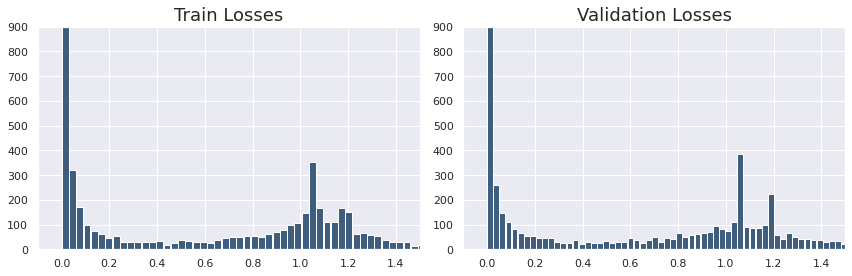

In [0]:
n = 3 if second_loop else 2
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

names = ["Train", "Validation"]
bins = [230, 380]
for name, loss, axis, b in zip(names, losses, ax, bins):
  axis.set_xlim(-0.1,1.5)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  hist = axis.hist(loss, bins=b, color="#3F5D7D", rwidth=.95)  
plt.tight_layout()
plt.show()
fig.savefig(path/"fig"/f"Loss_Hist{n}.eps")

# **An extra round of clean-up**

train: 9589/12335 = 78%  # of changed sampels: 4230
val: 5112/7308 = 70%  # of changed sampels: 907


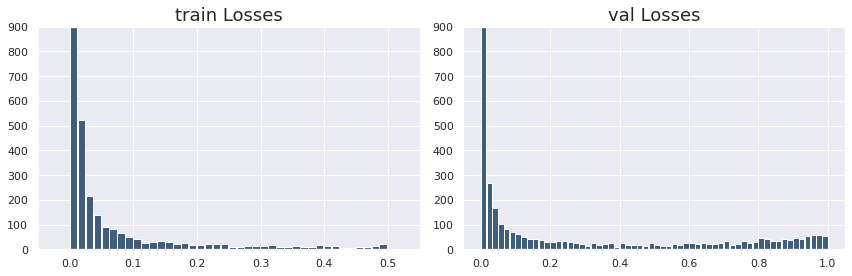

In [0]:
train = pd.read_csv(path_data/"Clean Data"/"train.csv")
val = pd.read_csv(path_data/"Clean Data"/"val.csv")

dfs = [train, val]
thresholds = [0.5, 1]
names = ["train", "val"]
bins = [40, 60]
xlims  = [(-.05, .55),(-.05, 1.05)]
n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize = (6*n_plots,4))

for loss, idx, th, df, name, axis, b, xlim in zip (losses, idxs, thresholds, dfs, names, ax, bins, xlims):
  # Adding a column clean to indicate the low loss samples
  n_good = (loss <= th).sum()
  good_idx = idx[-n_good:]
  clean = np.zeros(len(df), dtype=bool)
  clean[good_idx] = True
  df["clean2"] = clean
  df.to_csv(path_data/"Clean Data"/f"{name}.csv", index=False)

  # Printing new percentage of clean samples
  # and number of samples that changed type ie. they went from 
  # clean to dirty or viceversa
  changed_sampels = (df["clean2"] != df["clean"]).sum()
  p = float(n_good)/len(df)*100 
  print(f"{name}: {n_good}/{len(df)} = {p:0.0f}%  # of changed sampels: {changed_sampels}") 

  # Plotting hists of low loss images
  axis.set_xlim(*xlim)
  axis.set_ylim(0,900)
  axis.set_title(name + " Losses", fontsize=18)
  axis.hist(loss[-n_good:], bins=b, color="#3F5D7D", rwidth=.95)

plt.tight_layout()
plt.show()